# Classification with Python

Outline:
* Recap - Classification
* Part I
    * Load & Explore Data
        * Data Understanding
    * Data Analysis
        * Exploratory Data Analysis
        * Data Preparation
* Part II
    * Model Development
        * Data Preparation
        * Modelling
    * Model Evaluation
        * Confusion Matrix
        * Accuracy, Precision, Recall, F1-score

## Recap

Klasifikasi merupakan salah satu task dalam supervised learning yang mencoba memprediksi suatu input termasuk ke dalam kategori / kelas tertentu. Contoh kategori:
* Positive/Negative
* Music/Entertainment/Style/News/etc.

Di bawah ini adalah beberapa contoh ilustrasi _classification problem_ di dunia nyata:
<img src="https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationExample.png" width=50%/>

_(klasifikasi email spam atau bukan - [ref](https://developers.google.com/machine-learning/guides/text-classification))_


<img src="https://2.bp.blogspot.com/-KlBuhzV_oFw/WvxP_OAkJ1I/AAAAAAAACu0/T0F6lFZl-2QpS0O7VBMhf8wkUPvnRaPIACLcBGAs/s640/image2.gif" width=50%/>

_(smart compose di GMail - [ref](https://ai.googleblog.com/2018/05/smart-compose-using-neural-networks-to.html))_

## 0 Libraries

Cell berikut berisikan semua _library_ yang akan kita gunakan.

> Urutan penulisan _library_ mengikuti konvensi [PEP8](https://peps.python.org/pep-0008/)

In [1]:
import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score, \
                            recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.style.use("fivethirtyeight")

## 1 Data Loading

* Kita akan menggunakan dataset [Personal Key Indicators of Heart Disease](https://www.kaggle.com/datasets/kamilpytlak/personal-key-indicators-of-heart-disease) yang tersedia di [Kaggle](https://kaggle.com/). 

* Dataset ini merupakan data survei CDC tahun 2020 dari 400k orang dewasa yang berkaitan dengan kondisi kesehatan mereka. Dengan menggunakan dataset ini, kita akan membuat sebuah model untuk mengklasifikasikan apakah seseorang dengan kondisi kesehatan tertentu memiliki sakit jantung atau tidak yang direpresentasikan oleh fitur `HeartDisease`.

* Untuk menggunakan dataset ini, silakan unduh melalui link di atas, lalu unggah ke ruang kerja Google Colab kalian.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Panggil dataset heart_2020_clened.csv mengunakan function pandas yaitu read_csv()
# df_heart = pd.read_csv("heart_2020_cleaned.csv")
df_heart = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/heart_2020_cleaned.csv")
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [5]:
# Cek tipe data, jumlah baris, jumlah kolom, dan kelengkapan isi data (Non-Null)
df_heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

Dari informasi umum tentang dataset di atas, secara total, terdapat total **18 kolom/fitur** dan **319,795 baris**.

## 2. Exploratory Data Analysis (EDA)

Tujuan utama dari EDA adalah melakukan data understanding yang meliputi:
* analisis deskriptif
* eksplorasi data
* visualisasi data
* dll.

Karena sifatnya yang eksploratif, setiap orang mungkin akan memiliki cara dan pendekatan yang berbeda sesuai dengan asumsi dan kreativitas masing-masing.

<div align="center">
<img src="https://www.datascience-pm.com/wp-content/uploads/2021/02/CRISP-DM.png" width=50%/>
</div>

_(CRISP-DM - [ref](https://www.datascience-pm.com/crisp-dm-2/))_

### 2.1 Data Dictionary

Pertama, kita perlu mengetahui representasi setiap kolom pada data sebelum melakukan eksplorasi lebih jauh.

| column | description |
| ------ | ----------- |
| `HeartDisease` | Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI) |
| `BMI` | Body Mass Index (BMI) |
| `Smoking` | Have you smoked at least 100 cigarettes in your entire life? *(Note: 5 packs = 100 cigarettes)* |
| `AlcoholDrinking` | Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week |
| `Stroke` | (Ever told) (you had) a stroke? |
| `PhysicalHealth` | Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 |
| `MentalHealth` | Thinking about your mental health, for how many days during the past 30 days was your mental health not good? |
| `DiffWalking` | Do you have serious difficulty walking or climbing stairs? |
| `Sex` | Are you male of female |
| `AgeCategory` | Fourteen-level age category |
| `Race` | Imputed race/ethnicity value |
| `Diabetic` | (Ever told) (you had) diabetes? |
| `PhysicalActivity` | Adults who reported doing physical activity or exercise during the past 30 days other than their regular job |
| `GenHealth` | Would you say that in general your health is... |
| `SleepTime` | On average, how many hours of sleep do you get in a 24-hour period? |
| `Asthma` | (Ever told) (you had) asthma? |
| `KidneyDisease` | Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease? |
| `SkinCancer` | (Ever told) (you had) skin cancer? |

In [6]:
# Mengetahui kolom apa saja yang termasuk fitur (variabel) numerik/kategoris
numerical_features = df_heart.select_dtypes(include="number").columns.tolist()
categorical_features = df_heart.select_dtypes(include="object").columns.tolist()

print("Numerical features:")
pprint(numerical_features)
print("Categorical features:")
pprint(categorical_features, compact=True)

Numerical features:
['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']
Categorical features:
['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex',
 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma',
 'KidneyDisease', 'SkinCancer']


Masing-masing fitur numerik dan kategorik di atas terlihat cukup sesuai antara nama kolom dengan nilai-nilai di dalamnya.

> Sering kali ditemui dataset yang antara nama kolom dengan representasi nilainya tidak sesuai, misal kolom tanggal dan/atau waktu yang sering dianggap `object`. Untuk kasus seperti ini, kita perlu melakukan transformasi tipe data.

### 2.2 Summary Statistic

Untuk mengetahui informasi yang ada pada fitur numerik, kita tidak mungkin melihat satu per satu data dari 300 ribuan data yang ada. Untuk itu, kita menggunakan 5 summary statistic yang terdiri dari min, max, Q1, median, dan Q3 dari sebuah data (fitur).

Kita bisa menggunakan metode `describe` pada Pandas DataFrame untuk masing-masing fitur-fitur numerik dan sekaligus kategorik, seperti di bawah ini. 


In [7]:
# Memahami karakteristik data melalui fitur-fitur numerik dengan function describe()
df_heart[numerical_features].describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,319795.0,28.325399,6.356100,12.02,24.03,27.34,31.42,94.85
PhysicalHealth,319795.0,3.371710,7.950850,0.00,0.00,0.00,2.00,30.00
MentalHealth,319795.0,3.898366,7.955235,0.00,0.00,0.00,3.00,30.00
SleepTime,319795.0,7.097075,1.436007,1.00,6.00,7.00,8.00,24.00


Dari ringkasan stastistik di atas:
* Median dari `PhysicalHealth` dan `MentalHealth` lebih kecil daripada rata-rata nya, sehingga kemungkinan distribusinya left-skewed
* Kebanyakan nilai `PhysicalHealth` dan `MentalHealth` antara 0 sampai 3 (dari Q1 sampai Q3), sehingga kemungkinan terdapat banyak pencilan

> _**Hal menarik apalagi yang bisa kamu temukan dari tabel ringkasan di atas?**_

Untuk melihat lebih detail sebaran pada fitur-fitur numerik di atas, kita bisa buat box plot seperti di bawah ini.

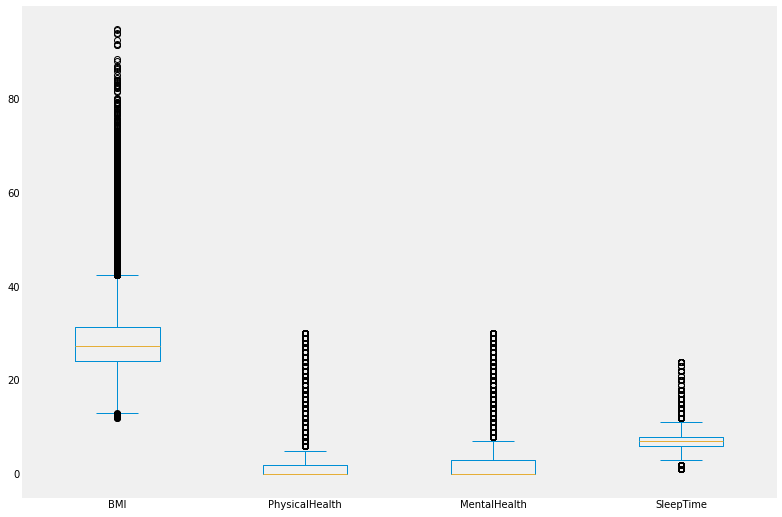

In [8]:
# Visualisasikan fitur-fitur numerik ke Boxplot untuk melihat bagaimana data tersebar
df_heart[numerical_features].plot(kind="box", figsize=(12, 9))
plt.grid(False)
plt.show()

> **Insights:** 

Dari visualisasi box plot di atas:
* Semua distribusi `BMI`, `PhysicalHealth`, `MentalHealth`, `SleepTime` terlihat right-skewed
* Meski begitu, nilai rata-rata dan median `BMI` dan `SleepTime` cenderung sama

Selain menggnakan boxplot seperti di atas, kita juga bisa menggunakan violin plot seperti di bawah ini untuk mengetahui bentuk kurva distribusi masing-masing fitur dengan lebih jelas.

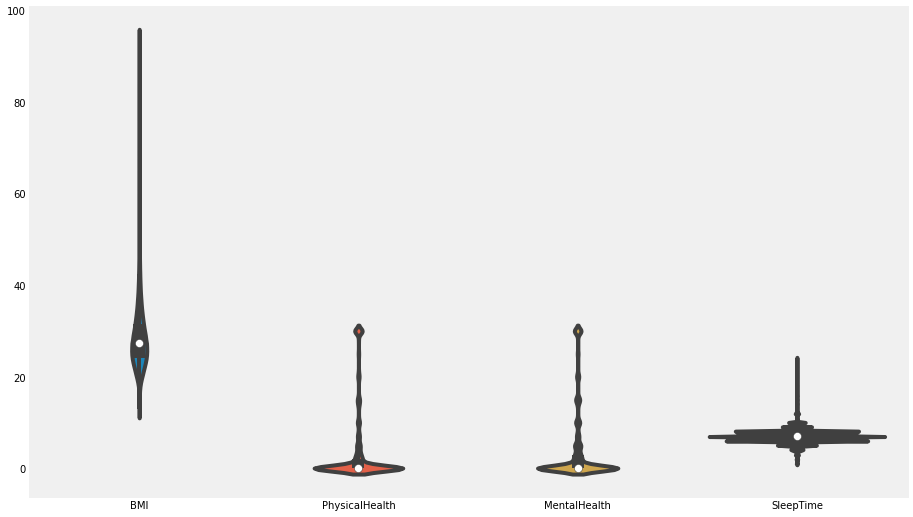

In [9]:
# Visualisasikan fitur-fitur numerik ke Violin Plot untuk melihat bentuk kurva distribusi data
plt.figure(figsize=(14, 9))
sns.violinplot(data=df_heart[numerical_features])
plt.grid(False)
plt.show()

* Berbeda dengan fitur numerik, ringkasan statistik untuk fitur-fitur kategorik terdiri dari jumlah baris pada data, jumlah nilai unik, nilai yang paling sering muncul (mode), dan frekuensinya.

In [10]:
# Memahami karakteristik data melalui fitur-fitur kategoris dengan function describe()
df_heart[categorical_features].describe().T

,count,unique,top,freq
HeartDisease,319795,2,No,292422
Smoking,319795,2,No,187887
AlcoholDrinking,319795,2,No,298018
Stroke,319795,2,No,307726
DiffWalking,319795,2,No,275385
Sex,319795,2,Female,167805
AgeCategory,319795,13,65-69,34151
Race,319795,6,White,245212
Diabetic,319795,4,No,269653
PhysicalActivity,319795,2,Yes,247957


Dari tabel ringkasan di atas:
* kebanyakan fitur kategorik berjenis binary boolean -> Yes / No
* kebanyakan gender adalah “female”
* kebanyakan orang beranggapan bahwa kesehatan mereka secara umum “Very Good”

> _**Hal menarik apa yang bisa kamu ambil dari tabel ringkasan statistik di atas?**_

### 2.3 Correlation

Dengan menggunakan korelasi, kita bisa mengukur seberapa kuat hubungan antara kedua variabel numerik. Kita bisa menggunakan metode `corr` dari Pandas DataFrame untuk membuat matriks koefisien korelasi antar pasangan fitur-fitur numerik.

In [11]:
# Melihat hubungan dari fitur numerik menggunakan correlation 
df_heart.corr()

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.109788,0.064131,-0.051822
PhysicalHealth,0.109788,1.000000,0.287987,-0.061387
MentalHealth,0.064131,0.287987,1.000000,-0.119717
SleepTime,-0.051822,-0.061387,-0.119717,1.000000


* Untuk lebih jelas dalam mengetahui pasangan fitur mana yang memiliki koefisien korelasi yang kuat (mendekati 1 atau mendekati -1), kita bisa buat plot heatmap berikut.

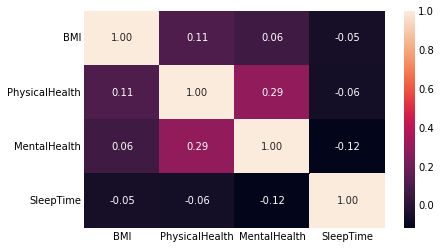

In [12]:
# Visualisasikan correlation coefficient di atas dengan bantuan heat map
sns.heatmap(df_heart.corr(), annot=True, fmt=".2f")
plt.show()

> Menurut kamu, bagaimana nilai korelasi antar fitur-fitur numerik di atas?

### 2.4 EDA on Categorical Features

Beberapa eksplorasi yang bisa dilakukan pada fitur kategorik meliputi:
* Analisis univariat
* Analisis multivariat
* Two-way table
* Bar plot
* dan lainnya

Pertama, mari kita tampilkan 5 baris pertama dari fitur kategorik pada data.

In [13]:
# Menampilkan semua kolom yang berisikan fitur kategoris di 5 baris teratas
df_heart[categorical_features].head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,No,Yes,No,No,No,Female,55-59,White,Yes,Yes,Very good,Yes,No,Yes
1,No,No,No,Yes,No,Female,80 or older,White,No,Yes,Very good,No,No,No
2,No,Yes,No,No,No,Male,65-69,White,Yes,Yes,Fair,Yes,No,No
3,No,No,No,No,No,Female,75-79,White,No,No,Good,No,No,Yes
4,No,No,No,No,Yes,Female,40-44,White,No,Yes,Very good,No,No,No


### 2.5 Number of Unique Values

* Dengan menggunakan metode `nunique`, kita peroleh jumlah nilai unik tiap fitur kategoris. Terlihat bahwa kebanyakan dari fitur kategoris pada data hanya memiliki 2 nilai unik saja.

* Meski begitu, fitur `AgeCategory` memiliki jumlah nilai unik yang paling banyak, yaitu 13 nilai unik


In [14]:
# Karena sifatnya yang kategorik, kita akan melihat unique values di tiap masing-masing kolom
df_heart[categorical_features].nunique()

HeartDisease         2
Smoking              2
AlcoholDrinking      2
Stroke               2
DiffWalking          2
Sex                  2
AgeCategory         13
Race                 6
Diabetic             4
PhysicalActivity     2
GenHealth            5
Asthma               2
KidneyDisease        2
SkinCancer           2
dtype: int64

* Untuk melihat nilai-nilai pada setiap fitur kategorik di atas, kita bisa menggunakan metode `value_counts` untuk menampilkan frekuensi masing-masing nilai untuk suatu kolom.

In [15]:
# Dari masing-masing unique values, kita akan coba melihat frequency tiap value di tiap kolom
for feature in categorical_features:
    print(df_heart[feature].value_counts())
    print ('------')

No     292422
Yes     27373
Name: HeartDisease, dtype: int64
------
No     187887
Yes    131908
Name: Smoking, dtype: int64
------
No     298018
Yes     21777
Name: AlcoholDrinking, dtype: int64
------
No     307726
Yes     12069
Name: Stroke, dtype: int64
------
No     275385
Yes     44410
Name: DiffWalking, dtype: int64
------
Female    167805
Male      151990
Name: Sex, dtype: int64
------
65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: AgeCategory, dtype: int64
------
White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: Race, dtype: int64
------
No            

### 2.6 Visualization

* Selain summary statistic, visualisasi juga merupakan teknik dalam mendeskripsikan bagaimana data yang kita miliki.  

#### 2.6.1 Age Category

* Karena fitur `AgeCategory` berjenis kategorik, kita bisa membuat bar plot untuk mengetahui kategori umur mana yang paling dominan.

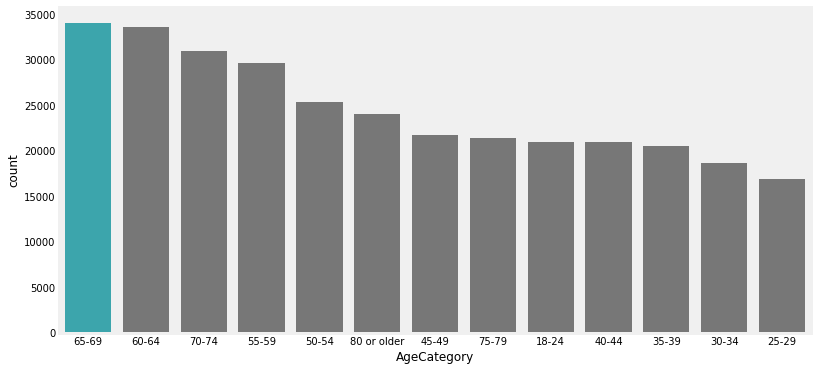

In [16]:
age_category_order = df_heart.AgeCategory.value_counts().index

plt.figure(figsize=(12, 6))
sns.countplot(
    x="AgeCategory",
    data=df_heart,
    order=age_category_order,
    palette=["#29B5BF"] + (len(age_category_order)-1)*["#777777"]
)
plt.grid(False)
plt.show()

> **Insights:** 

* Dari visualisasi di atas, terlihat bahwa kategori umum **65-69** paling banyak dijumpai.

* Lalu, bagaimana distribusi kategori umur pada masing-masing responden yang memiliki sakit jantung maupun tidak? Mari kita buat visualisasinya.

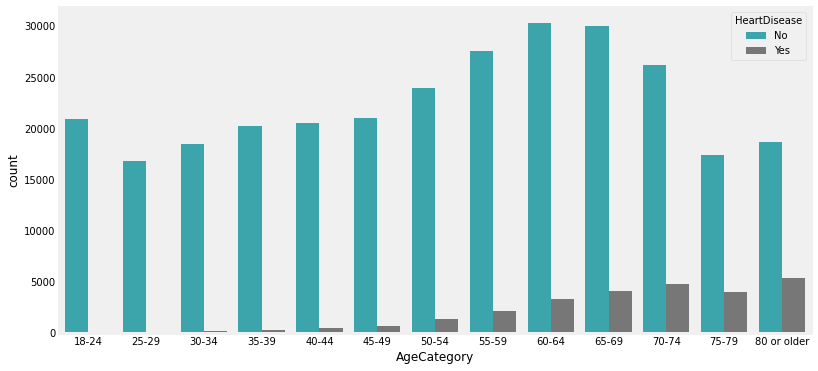

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(
    x="AgeCategory",
    data=df_heart,
    hue="HeartDisease",
    order=sorted(df_heart.AgeCategory.unique()),
    palette=["#29B5BF"] + ["#777777"]
)
plt.grid(False)
plt.show()

> **Insights:** 

Dari visualisasi di atas, terlihat bahwa untuk kategori umur di bawah 30 tahun, hampir tidak ada responden yang memiliki penyakit jantung. Semakin tinggi kategori umur, semakin meningkat juga jumlah responden dengan penyakit jantung.

* Selanjutnya, untuk kemudahan visualisasi fitur yang lain, kita akan menggunakan fungsi berikut.

In [18]:
def plot_count(x, data=df_heart, palette=None, figsize=(12, 6), **kwargs):
    column_order = data[x].value_counts().index

    plt.figure(figsize=figsize)
    sns.countplot(
        x=x, data=data, order=column_order,
        palette=palette, **kwargs
    )
    plt.grid(False)
    plt.show()

#### 2.5.2 Race

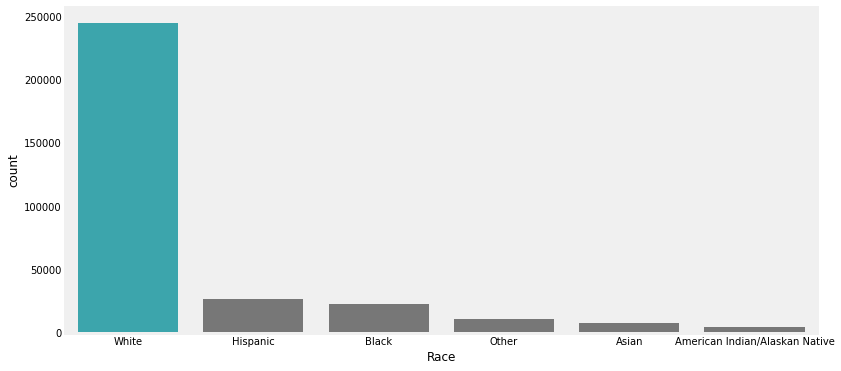

In [19]:
race_order = df_heart["Race"].value_counts().index
plot_count(
    "Race", palette=["#29B5BF"] + (len(race_order)-1)*["#777777"]
)

> **Insights:**  

* Terlihat bahwa dari 6 suku yang ada, `White` menjadi yang paling banyak. Sedangkan untuk `Asian` berada pada urutan 2 terakhir.

* Mungkin kita bertanya, apakah ada pola pada fitur `Race` jika kita bandingkan dengan responden dengan atau tidak dengan penyakit jantung?

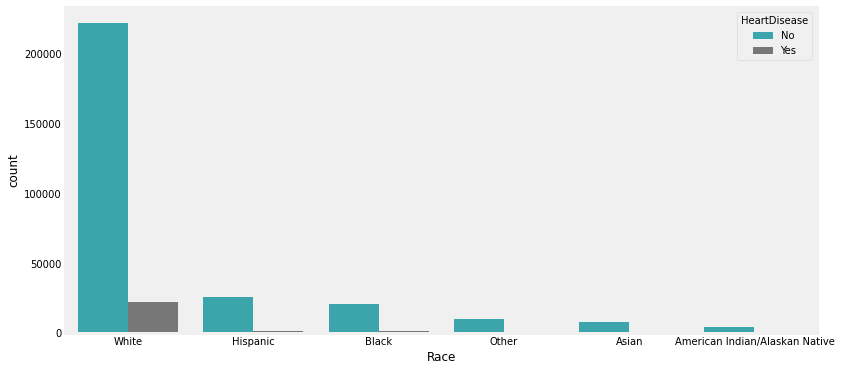

In [20]:
plot_count(
    "Race", palette=["#29B5BF"] + (len(race_order)-1)*["#777777"],
    hue="HeartDisease"
)

> **Insights:** 

* Terlihat bahwa kebanyakan responden yang memiliki penyakit jantung berasal dari ras `White`. 

* Bahkan, untuk nilai `Race` seperti `Asian`, `American Indian/Alaskan Native`, dan `Other` semua responden tampaknya tidak memiliki penyakit jantung "menurut data tersebut".

#### 2.5.3 General Health

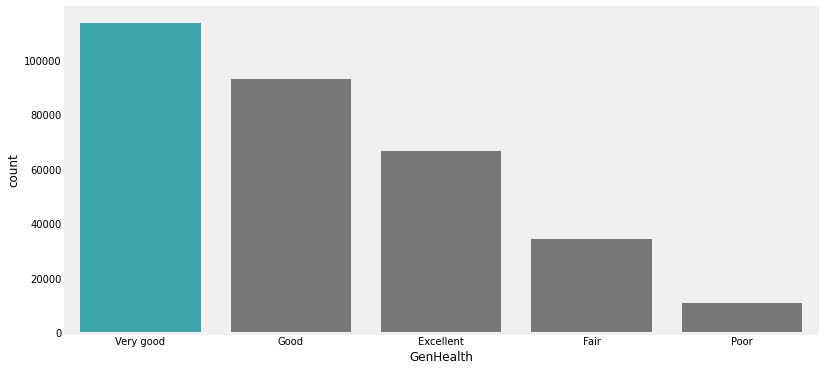

In [21]:
gen_health_order = df_heart["Race"].value_counts().index
plot_count(
    "GenHealth",
    palette=["#29B5BF"] + (len(gen_health_order)-1)*["#777777"]
)

> **Insights:** 

* Dari visualisasi di atas, bisa disimpulkan bahwa kebanyakan responden sangat percaya bahwa kondisi kesehatan mereka secara umum sangat baik.

* Sama seperti fitur sebelumnya, bagaimana jika kita hubungkan dengan kolom `HeartDisease`?

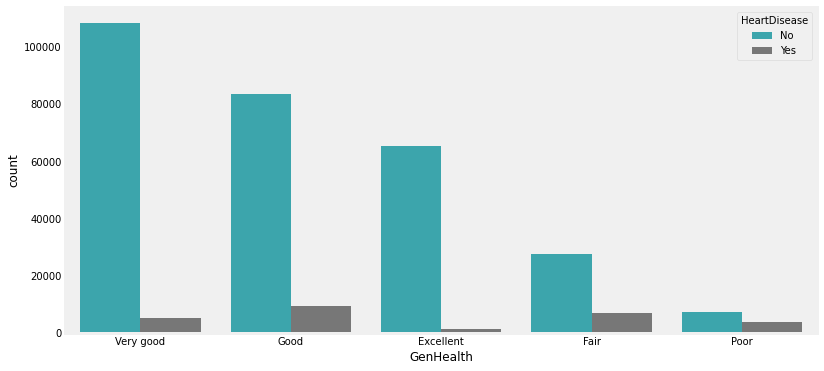

In [22]:
plot_count(
    x="GenHealth", palette=["#29B5BF"] + (len(gen_health_order)-1)*["#777777"],
    hue="HeartDisease"
)

> **Insights:** 

* Dari visualisasi di atas, terlihat bahwa responden yang menjawab kondisi kesehatan mereka secara umum dengan `Good` justru paling banyak yang memiliki penyakit jantung. 

* Meskipun begitu, secara persentase, responden yang menjawab `Poor` sebagian besar juga memiliki penyakit jantung.

#### 2.5.4 Sex

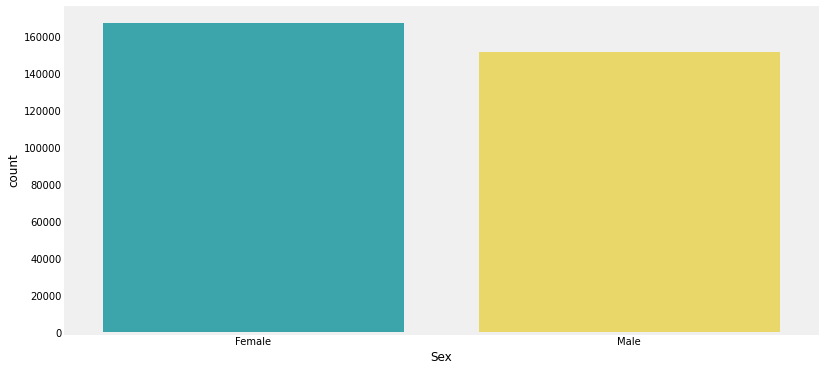

In [23]:
sex_order = df_heart["Sex"].value_counts().index
plot_count(
    "Sex",
    palette=["#29B5BF", "#FFE653"]
)

> **Insights:** 

* Antara laki-laki dan perempuan, proporsi responden hampir berimbang. Meskipun, persentase perempuan sedikit lebih banyak dibandingkan laki-laki. 

* Lalu, bagaimana hubungan kolom ini dengan kolom `HeartDisease`?

#### Exercise



---



---



In [ ]:
# buat visualisasi antara `Sex` dengan `HeartDisease`,
# apa yang bisa kamu ambil dari visualisasi tersebut?

## 3 Model Development



Mari kita lihat 5 baris pertama dari dataset heart disease.

In [24]:
df_heart.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


* Masih ingat dengan tipe data nominal, ordinal? Dari data di atas apa yang kalian bisa simpulkan sementara mengenai tipe data?

* Untuk memudahkan proses training, **langkah pertama**, kita akan buat variabel `X` yang berisi semua fitur-fitur untuk melatih model dan variabel `y` yang berisi target variabel.

In [25]:
# Define variable X (Independent variable/features)
X = df_heart.drop(columns=["HeartDisease"]).copy()

# Define variable y (Dependent variable/Target variable)
y = df_heart["HeartDisease"].copy()

### 3.1 Data Splitting

Seperti dijelaskan dalam slide, pada tahap ini, kita akan membagi dataset menjadi 3 set yaitu: 

* **training**, 

* **dev**, dan 

* **test** set 

dengan proporsi **90% : 5% : 5%**

> Proporsi pembagian dataset sedikit berbeda dari biasanya (70:20:10 / 80:10:10 / dst.) dikarenakan ukuran dataset yang sangat besar, sehingga jumlah development dan test data sudah cukup dengan proporsi yang kecil (**0.5%**)

In [26]:
# buat masing-masing set
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=.1, stratify=y, random_state=11)
X_dev, X_test, y_dev, y_test = train_test_split(X_rest, y_rest, test_size=.5, stratify=y_rest, random_state=11)

print(f"training size: {X_train.shape[0]} ({100*X_train.shape[0] / X.shape[0]:.3f}%)")
print(f"dev size: {X_dev.shape[0]} ({100*X_dev.shape[0] / X.shape[0]:.3f}%)")
print(f"test size: {X_test.shape[0]} ({100*X_test.shape[0] / X.shape[0]:.3f}%)")

training size: 287815 (90.000%)
dev size: 15990 (5.000%)
test size: 15990 (5.000%)


> *Notes*. Parameter `stratify` di atas digunakan untuk mencegah nilai `y` yang tidak seimbang antara data training, dengan data development, dan data test.

Sehingga kita peroleh:
* data training sebanyak **287,815** baris
* data development sebanyak **15,990** baris
* data test sebanyak **15,990** baris

Untuk lebih jelasnya, kita bisa buat visualisasi distribusi target variabel `y` untuk masing-masing data

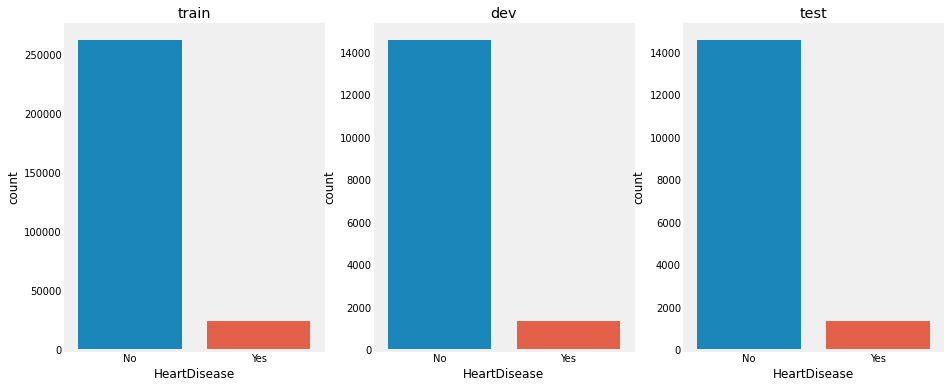

In [27]:
fig, axis = plt.subplots(1, 3, figsize=(14, 6))
for idx, label in enumerate([
    (y_train, "train"), (y_dev, "dev"), (y_test, "test")
]):
    sns.countplot(x=label[0], ax=axis[idx])
    axis[idx].set_title(label[1])
    axis[idx].grid(False)
plt.show()

### 3.2 Categorical Encoding

Seperti yang kita lihat dari isi value masing-masing fitur, maka encoding akan terbagi menjadi 2. 

1. Untuk fitur kategorik nominal, yaitu `Race` dan `Sex` akan diubah menjadi matriks one-hot, 

2. Sedangkan untuk fitur kategorik ordinal (sisa fitur kategorik lainnya, selain nominal variable) akan diubah ke dalam bentuk angka terurut.

In [28]:
nominal_features = ["Race", "Sex"]
ordinal_features = X.select_dtypes(
    include="object"
).drop(columns=nominal_features).columns.tolist()

print("nominal features:", nominal_features)
print("ordinal features:")
pprint(ordinal_features, compact=True)

nominal features: ['Race', 'Sex']
ordinal features:
['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'AgeCategory',
 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease',
 'SkinCancer']


In [29]:
# Encoding pada nominal features
onehot = OneHotEncoder()
onehot.fit(X_train[nominal_features])
X_train_onehot = pd.DataFrame(
    onehot.transform(X_train[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_dev_onehot = pd.DataFrame(
    onehot.transform(X_dev[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
X_test_onehot = pd.DataFrame(
    onehot.transform(X_test[nominal_features]).toarray(),
    columns=onehot.get_feature_names_out()
)
print("one-hot matrix:")
display(X_train_onehot)# tampilkan DataFrame hasil encoding

# Encoding pada ordinal features
ordinal = OrdinalEncoder()
ordinal.fit(X_train[ordinal_features])
X_train_ordinal = pd.DataFrame(
    ordinal.transform(X_train[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_dev_ordinal = pd.DataFrame(
    ordinal.transform(X_dev[ordinal_features]),
    columns=ordinal.feature_names_in_
)
X_test_ordinal = pd.DataFrame(
    ordinal.transform(X_test[ordinal_features]),
    columns=ordinal.feature_names_in_
)
print("ordinal matrix:")
display(X_train_ordinal)# tampilkan DataFrame hasil encoding

one-hot matrix:


,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Sex_Female,Sex_Male
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...
287810,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
287811,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
287812,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
287813,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


ordinal matrix:


,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
287810,1.0,1.0,0.0,0.0,2.0,0.0,1.0,4.0,1.0,0.0,0.0
287811,0.0,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,0.0
287812,1.0,0.0,0.0,0.0,8.0,0.0,1.0,4.0,0.0,0.0,0.0
287813,0.0,0.0,0.0,1.0,12.0,0.0,1.0,1.0,0.0,0.0,1.0


* Khusus untuk `AgeCategory`, kita perlu cek apakah encoding sudah sesuai dengan ekspektasi urutan rentang umur, yaitu umur yang lebih muda direpresentasikan dengan angka yang lebih rendah juga.

In [30]:
# Sanity check - check order of the resulting encoding of AgeCategory feature
pd.concat(
    [X_train.AgeCategory.reset_index(drop=True), X_train_ordinal.AgeCategory],
    axis=1,
    ignore_index=True
).groupby(1)[0].agg(set)

1
0.0           {18-24}
1.0           {25-29}
2.0           {30-34}
3.0           {35-39}
4.0           {40-44}
5.0           {45-49}
6.0           {50-54}
7.0           {55-59}
8.0           {60-64}
9.0           {65-69}
10.0          {70-74}
11.0          {75-79}
12.0    {80 or older}
Name: 0, dtype: object

### 3.3 Data Rescaling

* Tahap selanjutnya, kita akan menggunakan function `StandardScaler` dari `scikit-learn` sedemikian hingga nilai fitur-fitur numerik memiliki rata-rata 0 dan standar deviasi 1.

* Tapi, sebelum itu, kita akan menggabungkan antara fitur numerik dengan fitur kategorik yang sudah kita ubah ke dalam bentuk numerik.

> Perlu diperhatikan, untuk mencegah **data leakage**, kita akan melakukan `fit` pada data training saja.

> _Data leakage refers to **a mistake make by the creator of a machine learning model in which they accidentally share information between the test and training data-sets**_ ([ref](https://towardsdatascience.com/data-leakage-in-machine-learning-10bdd3eec742)).

In [31]:
# Menggabungkan DataFrame menggunakan pandas function pd
X_train_combined = pd.concat(
    [X_train[numerical_features].reset_index(drop=True), X_train_onehot, X_train_ordinal],
    axis=1
)
X_dev_combined = pd.concat(
    [X_dev[numerical_features].reset_index(drop=True), X_dev_onehot, X_dev_ordinal],
    axis=1
)
X_test_combined = pd.concat(
    [X_test[numerical_features].reset_index(drop=True), X_test_onehot, X_test_ordinal],
    axis=1
)

X_train_combined.head()

,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,...,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,23.23,0.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0
1,31.32,2.0,0.0,5.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,0.0,0.0
2,27.40,0.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,9.0,0.0,1.0,2.0,0.0,0.0,0.0
3,28.12,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,12.0,0.0,1.0,4.0,0.0,0.0,1.0
4,23.17,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,10.0,0.0,1.0,0.0,0.0,0.0,0.0


Kemudian, kita akan mulai melakukan tahap _rescaling_.

In [32]:
# Panggil function StandardScaler dari package scikit-learn
scaler = StandardScaler()
scaler.fit(X_train_combined)

X_train_scaled = pd.DataFrame(
    scaler.transform(X_train_combined),
    columns=X_train_combined.columns
)
X_dev_scaled = pd.DataFrame(
    scaler.transform(X_dev_combined),
    columns=X_dev_combined.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test_combined),
    columns=X_test_combined.columns
)

with pd.option_context("display.max_columns", None):
    display(X_train_scaled.head())

,BMI,PhysicalHealth,MentalHealth,SleepTime,Race_American Indian/Alaskan Native,Race_Asian,Race_Black,Race_Hispanic,Race_Other,Race_White,Sex_Female,Sex_Male,Smoking,AlcoholDrinking,Stroke,DiffWalking,AgeCategory,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,-0.800865,-0.423539,0.392302,-1.461103,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,0.951852,-0.951852,-0.837284,-0.269644,-0.19784,-0.401596,0.696455,-0.418921,-1.856446,-0.795960,2.537974,5.112936,-0.320418
1,0.470906,-0.171718,-0.489480,-1.461103,-0.128258,-0.161182,3.598695,-0.306615,-0.187958,-1.813109,0.951852,-0.951852,-0.837284,-0.269644,-0.19784,-0.401596,-1.826633,-0.418921,0.538664,1.158765,-0.394015,-0.195582,-0.320418
2,-0.145329,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,5.320346,-1.813109,0.951852,-0.951852,1.194338,-0.269644,-0.19784,-0.401596,0.696455,-0.418921,0.538664,-0.144385,-0.394015,-0.195582,-0.320418
3,-0.032143,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,-1.050584,1.050584,-0.837284,-0.269644,-0.19784,-0.401596,1.537484,-0.418921,0.538664,1.158765,-0.394015,-0.195582,3.120924
4,-0.810297,-0.423539,-0.489480,0.629343,-0.128258,-0.161182,-0.277878,-0.306615,-0.187958,0.551539,0.951852,-0.951852,1.194338,-0.269644,-0.19784,-0.401596,0.976798,-0.418921,0.538664,-1.447535,-0.394015,-0.195582,-0.320418


* Setelah kita melakukan rescaling terhadap data, tahap selanjutnya yaitu kita akan masuk dalam tahap membangun pemodelan (*Modeling*)

### 3.4 Modeling

* Kita akan menggunakan `DecisionTreeClassifier` dari `scikit-learn`. Ada beberapa [(hyper)parameter](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) yang bisa kita tentukan saat mendefisinikan model.

* Sebagai awalan, kita akan menggunakan _default_ parameter yang disediakan oleh `scikit-learn` apa adanya.

In [33]:
# Panggil function DecisionTreeClassifier() dari scikit-learn
model_default = DecisionTreeClassifier(random_state=11)

# Terapkan model tersebut menggunakan funciton fit() untuk membuat model berdasarkan set training
model_default.fit(X_train_scaled, y_train)

# Dengan menggunakan model yang sudah dibuat, hitung prediksi dengan menggunakan function predict() di tiap set
preds_train = model_default.predict(X_train_scaled)
preds_dev = model_default.predict(X_dev_scaled)
preds_test = model_default.predict(X_test_scaled)

In [34]:
# training set
print("train prediction samples:\n", preds_train[:10])
print("train target samples:\n", y_train[:10].tolist())

train prediction samples:
 ['No' 'No' 'No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No']
train target samples:
 ['No', 'No', 'No', 'No', 'No', 'Yes', 'No', 'No', 'No', 'No']


In [35]:
# development set
print("dev prediction samples:\n", preds_dev[:10])
print("dev target samples:\n", y_dev[:10].tolist())

dev prediction samples:
 ['No' 'No' 'No' 'No' 'No' 'No' 'No' 'No' 'Yes' 'No']
dev target samples:
 ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'Yes', 'No']


In [36]:
# testing set
print("test prediction samples:\n", preds_test[:10])
print("test target samples:\n", y_test[:10].tolist())

test prediction samples:
 ['No' 'No' 'No' 'Yes' 'No' 'No' 'No' 'No' 'No' 'No']
test target samples:
 ['No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No', 'No']


> Di tahap ini kita telah mendapatkan hasil prediksi menggunakan scikit-learn. Selanjutnya, kita akan coba buat model Decision Tree yang lebih sederhana dengan mengatur _(hyper)parameter_ yang ada.

In [37]:
# Panggil function DecisionTreeClassifier() dari scikit-learn dan atur parameter
simpler_model = DecisionTreeClassifier(
    max_depth=7, min_samples_split=int(1e3),
    random_state=11
)
simpler_model.fit(X_train_scaled, y_train)

preds_train_simpler = simpler_model.predict(X_train_scaled)
preds_dev_simpler = simpler_model.predict(X_dev_scaled)
preds_test_simpler = simpler_model.predict(X_test_scaled)

* Kita bisa membuat visualisasi model Decision Tree yang sudah dilatih supaya kita bisa melihat bagaimana model bisa melakukan prediksi dan fitur-fitur mana yang menjadi root node ataupun decision node.

> karena kita menggunakan hyperparameter default model, proses visualisasi model mungkin akan memakan waktu yang cukup lama untuk seluruh level. Oleh karena itu, kita akan coba visualisasi 5 level pertama model saja.

In [38]:
# long running code with full depth
# plot_tree(model_default)
# plt.show()

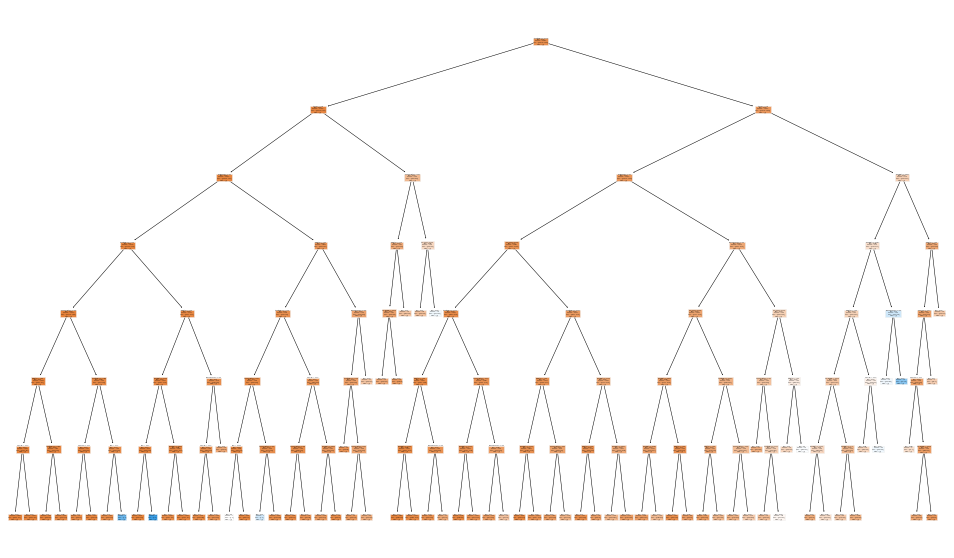

In [39]:
plt.figure(figsize=(15, 10))
plot_tree(
    simpler_model,
    feature_names=simpler_model.feature_names_in_,
    class_names=True,
    filled=True,
)
plt.show()

### 3.5 Model Evaluation

* Salah satu cara paling mudah untuk mengukur hasil prediksi suatu model klasifikasi adalah dengan melihat akurasi, yaitu perbandingan antara jumlah hasil prediksi tepat dengan jumlah total data yang ada.

* Kita akan melihat berapa accuracy_score dari masing-masing model

#### **Accuracy Score**

In [40]:
# Terapkan function accuracy_score() pada masing-masing model
print(
    "Training accuracy on default model:",
    accuracy_score(y_train, preds_train)
)
print(
    "Training accuracy on simpler model:",
    accuracy_score(y_train, preds_train_simpler)
)
print()
print(
    "Dev accuracy on default model:",
    accuracy_score(y_dev, preds_dev)
)
print(
    "Dev accuracy on simpler model:",
    accuracy_score(y_dev, preds_dev_simpler)
)
print()
print(
    "Test accuracy on default model:",
    accuracy_score(y_test, preds_test)
)
print(
    "Test accuracy on simpler model:",
    accuracy_score(y_test, preds_test_simpler)
)

Training accuracy on default model: 0.9965081736532148
Training accuracy on simpler model: 0.9152650139846776

Dev accuracy on default model: 0.8633520950594121
Dev accuracy on simpler model: 0.916635397123202

Test accuracy on default model: 0.8594746716697936
Test accuracy on simpler model: 0.914383989993746


* Metrik lain yang sering digunakan adalah precision, recall, dan f1-score, dimana rumus dari masing-masing metrik adalah sbb:

<div align="center">
<img src="https://miro.medium.com/max/888/1*7J08ekAwupLBegeUI8muHA.png" width=50%/>
</div>

<div align="center">
<img src="https://miro.medium.com/max/564/1*T6kVUKxG_Z4V5Fm1UXhEIw.png" width=40%/>
</div>

#### **Precision Score**

In [41]:
# Terapkan function precision_score pada masing-masing model

print(
    "Training precision on default model:",
    precision_score(y_train, preds_train, pos_label="Yes")
)
print(
    "Training precision on simpler model:",
    precision_score(y_train, preds_train_simpler, pos_label="Yes")
)
print()
print(
    "Dev precision on default model:",
    precision_score(y_dev, preds_dev, pos_label="Yes")
)
print(
    "Dev precision on simpler model:",
    precision_score(y_dev, preds_dev_simpler, pos_label="Yes")
)
print()
print(
    "Test precision on default model:",
    precision_score(y_test, preds_test, pos_label="Yes")
)
print(
    "Test precision on simpler model:",
    precision_score(y_test, preds_test_simpler, pos_label="Yes")
)

Training precision on default model: 0.9991129134456976
Training precision on simpler model: 0.5384138785625775

Dev precision on default model: 0.22638981915606163
Dev precision on simpler model: 0.5935828877005348

Test precision on default model: 0.21080368906455862
Test precision on simpler model: 0.5


#### **Recall Score**

In [42]:
print(
    "Training recall on default model:",
    recall_score(y_train, preds_train, pos_label="Yes")
)
print(
    "Training recall on simpler model:",
    recall_score(y_train, preds_train_simpler, pos_label="Yes")
)
print()
print(
    "Dev recall on default model:",
    recall_score(y_dev, preds_dev, pos_label="Yes")
)
print(
    "Dev recall on simpler model:",
    recall_score(y_dev, preds_dev_simpler, pos_label="Yes")
)
print()
print(
    "Test recall on default model:",
    recall_score(y_test, preds_test, pos_label="Yes")
)
print(
    "Test recall on simpler model:",
    recall_score(y_test, preds_test_simpler, pos_label="Yes")
)

Training recall on default model: 0.960058451047248
Training recall on simpler model: 0.07054716674784868

Dev recall on default model: 0.24707602339181287
Dev recall on simpler model: 0.08114035087719298

Test recall on default model: 0.2337472607742878
Test recall on simpler model: 0.07596785975164354


* Setelah kita bandingkan performa dari kedua model di atas untuk masing-masing metrik akurasi, precision, recall, dan juga f1-score, kira-kira model mana yang paling bagus?

* Kita masih bisa mengeksplor hyperparameter dari model Decision Tree tersebut untuk mencari tahu konfigurasi yang paling bagus atau kita juga bisa menggunakan model lain seperti Logistic Regression atau Random Forest, tapi ini tidak akan dibahasa karena diluar cakupan materi ini.

> *Notes*. 4 metrik di atas bisa kita hitung secara sekaligus dengan fungsi `classification_report` dari scikit-learn. Kita akan coba di code cell berikutnya.

> Selain itu, untuk melihat visualisasi dan rangkuman dari performa model classification kita juga bisa menggunakan  _confusion matrix_ yang merupakan sebuah matriks/tabel yang terdiri dari report semua kemungkinan prediksi. 

> Ada 4 kemungkinan:
* **True Positive (TP)**: sampel yang sebenarnya True/1 berhasil diprediksi oleh model sebagai True/Positive
* **True Negative (TN)**: sample yang sebenarnya False/0 berhasil diprediksi oleh model sebagai False/0
* **False Positive (FP)**: sampel yang sebenarnya False/0, tapi diprediksi oleh model sebagai True/1
* **False Negative (FN)**: sampel yang sebenarnya True/1, tapi diprediksi oleh model sebagai False/0


#### **I. Classification Report & Confusion Matrix: Default model and Simpler model on training data set**

Default model performance on training set..
              precision    recall  f1-score   support

          No       1.00      1.00      1.00    263179
         Yes       1.00      0.96      0.98     24636

    accuracy                           1.00    287815
   macro avg       1.00      0.98      0.99    287815
weighted avg       1.00      1.00      1.00    287815



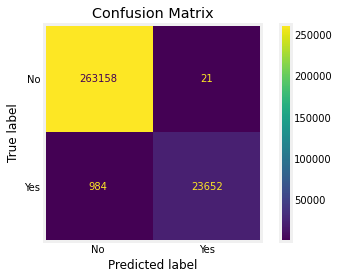

Simpler model performance on training set..
              precision    recall  f1-score   support

          No       0.92      0.99      0.96    263179
         Yes       0.54      0.07      0.12     24636

    accuracy                           0.92    287815
   macro avg       0.73      0.53      0.54    287815
weighted avg       0.89      0.92      0.88    287815



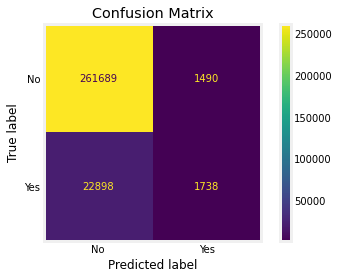

In [43]:
print("Default model performance on training set..")
print(classification_report(y_train, preds_train))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, preds_train)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("Simpler model performance on training set..")
print(classification_report(y_train, preds_train_simpler))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_train, preds_train_simpler)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> **Insights**

Insight yang diperoleh dari evaluasi model pada data training adalah:
* dari **default model**, semua **evaluation metrics sangat bagus**, mulai dari **accuracy**, **precision**, **recall**, dan **f1-score**
* dari **24,636 data yang berlabel `Yes`**, model gagal memprediksi **984 data** dengan benar (**false negative**). Ini berarti, ada **984** orang yang seharusnya memiliki riwayat penyakit jantung, tapi model mengklasifikan mereka sebagai orang sehat

> Lalu, apa yang bisa kamu ambil dari evaluasi model yang satu lagi?

#### **II. Classification Report & Confusion Matrix:  Default model and Simpler model on dev data set**

Default model performance on dev set...
              precision    recall  f1-score   support

          No       0.93      0.92      0.92     14622
         Yes       0.23      0.25      0.24      1368

    accuracy                           0.86     15990
   macro avg       0.58      0.58      0.58     15990
weighted avg       0.87      0.86      0.87     15990



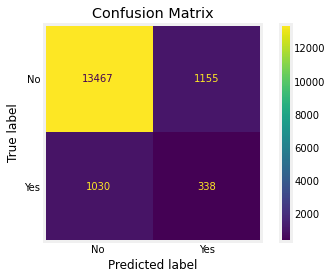

Simpler model performance on dev set...
              precision    recall  f1-score   support

          No       0.92      0.99      0.96     14622
         Yes       0.59      0.08      0.14      1368

    accuracy                           0.92     15990
   macro avg       0.76      0.54      0.55     15990
weighted avg       0.89      0.92      0.89     15990



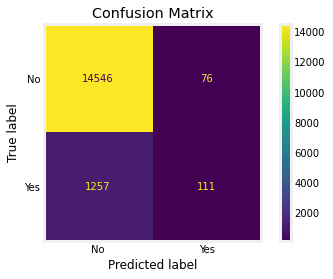

In [44]:
print("Default model performance on dev set...")
print(classification_report(y_dev, preds_dev))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("Simpler model performance on dev set...")
print(classification_report(y_dev, preds_dev_simpler))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_dev, preds_dev_simpler)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> **Question**

Insights apa yang bisa diambil dari evaluasi kedua model dengan data development di atas?

#### **III. Classification Report & Confusion Matrix: Default model and Simpler model on test data set**

Default model performance on test set...
              precision    recall  f1-score   support

          No       0.93      0.92      0.92     14621
         Yes       0.21      0.23      0.22      1369

    accuracy                           0.86     15990
   macro avg       0.57      0.58      0.57     15990
weighted avg       0.87      0.86      0.86     15990



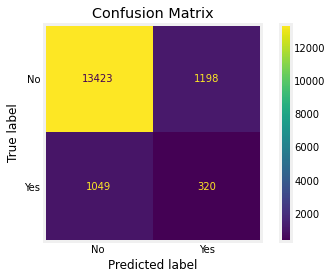

Simpler model performance on test set...
              precision    recall  f1-score   support

          No       0.92      0.99      0.95     14621
         Yes       0.50      0.08      0.13      1369

    accuracy                           0.91     15990
   macro avg       0.71      0.53      0.54     15990
weighted avg       0.88      0.91      0.88     15990



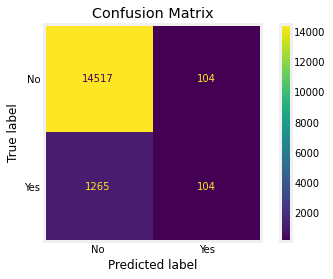

In [45]:
print("Default model performance on test set...")
print(classification_report(y_test, preds_test))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_test)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print("Simpler model performance on test set...")
print(classification_report(y_test, preds_test_simpler))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, preds_test_simpler)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

> **Question** 

* Menurut kalian insight apa yang bisa diambil dari evaluasi kedua model dengan data test di atas?

* Lalu untuk mendapatkan sebuah kesimpulan, apakah dengan model yang kita bangun ini dapat menjawab dari tujuan kita di awal?

### 3.6 Exporting results

Sebagai penutup, kita bisa melakukan prediksi untuk seluruh data dan menyimpan hasil prediksi menjadi sebuah file CSV seperti berikut.

In [46]:
X.head()

,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [47]:
ordinal.feature_names_in_.tolist()

['Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'AgeCategory',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [48]:
numerical_features + onehot.get_feature_names_out().tolist() + ordinal.feature_names_in_.tolist()

['BMI',
 'PhysicalHealth',
 'MentalHealth',
 'SleepTime',
 'Race_American Indian/Alaskan Native',
 'Race_Asian',
 'Race_Black',
 'Race_Hispanic',
 'Race_Other',
 'Race_White',
 'Sex_Female',
 'Sex_Male',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'AgeCategory',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [50]:
column_names = (
    numerical_features
    + onehot.get_feature_names_out().tolist()
    + ordinal.feature_names_in_.tolist()
)
X_processed = pd.concat(
    [
     # numerical features
     X[numerical_features].reset_index(drop=True),
     # one-hot encoded features
     pd.DataFrame(
         onehot.transform(X[nominal_features]).toarray(),
         columns=onehot.get_feature_names_out().tolist()
     ),
     # ordinal encoded features
     pd.DataFrame(
         ordinal.transform(X[ordinal_features]),
         columns=ordinal.feature_names_in_.tolist()
     ),
    ],
    axis=1
)
X_processed_scaled = pd.DataFrame(
    scaler.transform(X_processed),
    columns=X_processed.columns
)

print("Predicting all {} data..".format(X_processed_scaled.shape[0]))
preds_full = model_default.predict(X_processed_scaled)

print("Combine the prediction back to the original data..")
X = X.assign(prediction=preds_full)

print("Overview of the resulting data..")
with pd.option_context("display.max_columns", None):
    display(X.head())

print("Export to CSV..")
X.to_csv("prediction.csv", index=False)

print("Done!")

Predicting all 319795 data..
Combine the prediction back to the original data..
Overview of the resulting data..


,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer,prediction
0,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes,Yes
1,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No,No
2,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No,No
3,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes,No
4,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No,No


Export to CSV..
Done!
